
# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

# Web Server Log Analysis with Apache Spark**
 
 
Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

### Load the Logs Data into an RDD

In [1]:
logsRDD = sc.textFile('hdfs:///user/gmedasani/data/exercises-data/apache.access.log')

In [2]:
logsRDD.take(10)

[u'in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0',
 u'ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713',
 u'uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0',
 u'slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687',
 u'piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/launchmedium.gif HTTP/1.0" 200 11853',
 u'slppp6.intermind.net - - [01/Aug/1995:00:00:11 -

### Parse the logsRDD using the above regex

In [4]:
import re
import datetime
from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline,"failed","","","","","","",0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (match.group(1),match.group(2),match.group(3),parse_apache_time(match.group(4)),match.group(5),match.group(6),
        match.group(7),int(match.group(8)),size)

In [5]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [6]:
parsedLogsRDD = logsRDD.map(parseApacheLogLine).cache()

In [7]:
parsedLogsRDD.take(2)

[(u'in24.inetnebr.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 1),
  u'GET',
  u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt',
  u'HTTP/1.0',
  200,
  1839L),
 (u'uplherc.upl.com',
  u'-',
  u'-',
  datetime.datetime(1995, 8, 1, 0, 0, 7),
  u'GET',
  u'/',
  u'HTTP/1.0',
  304,
  0L)]

In [8]:
parsedLogsCount = parsedLogsRDD.count()

### Filter the logs that were not parsed correctly

In [56]:
failedLogsRDD = (parsedLogsRDD.filter(lambda s: s[1] == 'failed')
                .map(lambda s: s[0])
                .cache())
failedLogsCount = failedLogsRDD.count()

In [57]:
successfulLogsRDD = (parsedLogsRDD.filter(lambda s: s[1] != 'failed')
                .filter(lambda s: s[0])
                .cache())
successfulLogsCount = successfulLogsRDD.count()

In [58]:
 print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsedLogsCount, successfulLogsCount, 
                                                                                  failedLogsCount)

Read 1043177 lines, successfully parsed 1043069 lines, failed to parse 108 lines


### Data Cleaning

Create a new Apache Log pattern to parse all the logs successfully

In [9]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [10]:
parsedLogsNewRDD = logsRDD.map(parseApacheLogLine).cache()

In [11]:
parsedLogsNewCount = parsedLogsNewRDD.count()

In [12]:
failedLogsNewRDD = (parsedLogsNewRDD.filter(lambda s: s[1] == 'failed')
                .map(lambda s: s[0])
                .cache())
failedLogsNewCount = failedLogsNewRDD.count()

In [13]:
successfulLogsNewRDD = (parsedLogsNewRDD.filter(lambda s: s[1] != 'failed')
                .filter(lambda s: s[0])
                .cache())
successfulLogsNewCount = successfulLogsNewRDD.count()

In [14]:
print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsedLogsNewCount, 
                                                                                 successfulLogsNewCount,
                                                                                 failedLogsNewCount)

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


In [15]:
from test_helper import Test
# TEST Data cleaning (1c)
Test.assertEquals(failedLogsNewCount, 0, 'incorrect failed_logs.count()')
Test.assertEquals(successfulLogsNewCount, 1043177 , 'incorrect parsed_logs.count()')
Test.assertEquals(parsedLogsNewCount, 1043177, 'incorrect access_logs.count()')

1 test passed.
1 test passed.
1 test passed.


## Sample Analysis

### Content Size statistics on the Web Server Log File

In [16]:
parsedLogsNewRDD.map(lambda log: log[8]).take(10)

[1839L, 0L, 0L, 0L, 0L, 1713L, 0L, 1687L, 11853L, 9202L]

In [17]:
# Calculate statistics based on the content size.
content_sizesRDD = parsedLogsNewRDD.map(lambda log: log[8]).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizesRDD.reduce(lambda a, b : a + b) / content_sizesRDD.count(),
    content_sizesRDD.min(),
    content_sizesRDD.max())

Content Size Avg: 17531, Min: 0, Max: 3421948


### Response Code Analysis

In [18]:
# Response Code to Count
responseCodeToCount = (parsedLogsNewRDD
                       .map(lambda log: (log[7], 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList
assert len(responseCodeToCountList) == 7
assert sorted(responseCodeToCountList) == [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]

Found 7 response codes
Response Code Counts: [(200, 940847), (304, 79824), (404, 6185), (500, 2), (302, 16244), (403, 58), (501, 17)]


### Response Code Graphing with `matplotlib`

In [19]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = parsedLogsNewRDD.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 404, 500, 302, 403, 501]
[0.9019054292799784, 0.07652009198822443, 0.005929003419362198, 1.9172201841106543e-06, 0.015571662335346735, 5.5599385339208974e-05, 1.629637156494056e-05]


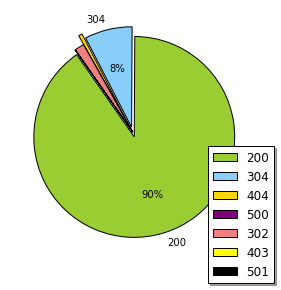

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

### Frequent Hosts

In [81]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = parsedLogsNewRDD.map(lambda log: (log[0], 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have accessed more then 10 times: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']


### Visualizing Endpoints


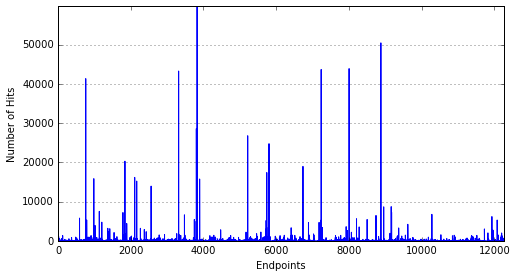

In [21]:
endpoints = (parsedLogsNewRDD
             .map(lambda log: (log[5], 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

### Top Endpoints

In [22]:
# Top Endpoints
endpointCounts = (parsedLogsNewRDD
                  .map(lambda log: (log[5], 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints
assert topEndpoints == [(u'/images/NASA-logosmall.gif', 59737), (u'/images/KSC-logosmall.gif', 50452), (u'/images/MOSAIC-logosmall.gif', 43890), (u'/images/USA-logosmall.gif', 43664), (u'/images/WORLD-logosmall.gif', 43277), (u'/images/ksclogo-medium.gif', 41336), (u'/ksc.html', 28582), (u'/history/apollo/images/apollo-logo1.gif', 26778), (u'/images/launch-logo.gif', 24755), (u'/', 20292)], 'incorrect Top Ten Endpoints'

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 59737), (u'/images/KSC-logosmall.gif', 50452), (u'/images/MOSAIC-logosmall.gif', 43890), (u'/images/USA-logosmall.gif', 43664), (u'/images/WORLD-logosmall.gif', 43277), (u'/images/ksclogo-medium.gif', 41336), (u'/ksc.html', 28582), (u'/history/apollo/images/apollo-logo1.gif', 26778), (u'/images/launch-logo.gif', 24755), (u'/', 20292)]


### Analyzing Web Server Log File

#### Top Ten Error Endpoints

What are the top ten endpoints which did not have return code 200? Create a sorted list containing top ten endpoints and the number of times that they were accessed with non-200 return code.
 
Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints, and sort the list.

In [23]:
not200 = parsedLogsNewRDD.filter(lambda x: x[7] != 200)

endpointCountPairTuple = not200.map(lambda x: (x[5],1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda v1,v2: v1+v2)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1*s[1])
print 'Top Ten failed URLs: %s' % topTenErrURLs

Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236), (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811), (u'/', 2199), (u'/images/ksclogosmall.gif', 1622)]


In [24]:
# TEST Top ten error endpoints
Test.assertEquals(endpointSum.count(), 7689, 'incorrect count for endpointSum')
Test.assertEquals(topTenErrURLs, [(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236),
                                  (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), 
                                  (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), 
                                  (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811)
                                  ,(u'/', 2199), (u'/images/ksclogosmall.gif', 1622)], 'incorrect Top Ten failed URLs (topTenErrURLs)')

1 test passed.
1 test passed.


#### Number of Unique Hosts

How many unique hosts are there in the entire log?
 
Think about the steps that you need to perform to count the number of different hosts in the log.

In [95]:
hosts = parsedLogsNewRDD.map(lambda x: x[0])

uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 54507


In [96]:
Test.assertEquals(uniqueHostCount, 54507, 'incorrect uniqueHostCount')

1 test passed.


####  Exercise: Number of Unique Daily Hosts

In [97]:
dayToHostPairTuple = parsedLogsNewRDD.map(lambda x: (x[3].day,x[0])).distinct()
#print dayToHostPairTuple.take(30)

dayGroupedHosts = dayToHostPairTuple.map(lambda (k,v):(k,1))

dayHostCount = dayGroupedHosts.reduceByKey(lambda v1,v2: v1+v2)

dailyHosts = (dayHostCount
              .sortByKey()
              .cache())
dailyHostsList = dailyHosts.take(30)
print 'Unique hosts per day: %s' % dailyHostsList

Unique hosts per day: [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)]


In [98]:
# TEST Number of unique daily hosts (3c)
Test.assertEquals(dailyHosts.count(), 21, 'incorrect dailyHosts.count()')
Test.assertEquals(dailyHostsList, [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)], 'incorrect dailyHostsList')
Test.assertTrue(dailyHosts.is_cached, 'incorrect dailyHosts.is_cached')

1 test passed.
1 test passed.
1 test passed.


#### Visualizing the Number of Unique Daily Hosts

In [99]:
daysWithHosts = dailyHosts.map(lambda x: x[0]).collect()
hosts = dailyHosts.map(lambda x:x[1]).collect()

In [100]:
# TEST Visualizing unique daily hosts
test_days = range(1, 23)
test_days.remove(2)
Test.assertEquals(daysWithHosts, test_days, 'incorrect days')
Test.assertEquals(hosts, [2582, 3222, 4190, 2502, 2537, 4106, 4406, 4317, 4523, 4346, 2864, 2650, 4454, 4214, 4340, 4385, 4168, 2550, 2560, 4134, 4456], 'incorrect hosts')

1 test passed.
1 test passed.


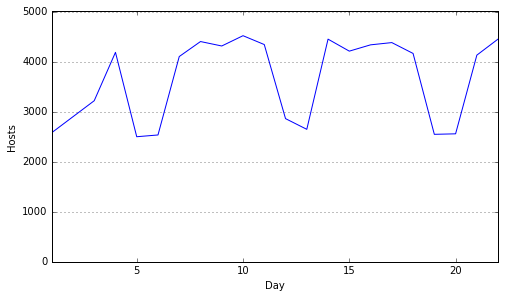

In [101]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

#### Average Number of Daily Requests per Hosts

In [103]:
dayAndHostTuple = parsedLogsNewRDD.map(lambda x: (x[3].day,1))

groupedByDay = dayAndHostTuple.reduceByKey(lambda v1,v2:v1+v2)

sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerHost = (sortedByDay
                      .join(dailyHosts)
                      .map(lambda (x,(v1,v2)):(x, v1/v2))
                      .sortByKey()
                      .cache())
avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print 'Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList

Average number of daily requests per Hosts is [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12), (7, 13), (8, 13), (9, 14), (10, 13), (11, 14), (12, 13), (13, 13), (14, 13), (15, 13), (16, 13), (17, 13), (18, 13), (19, 12), (20, 12), (21, 13), (22, 12)]


In [107]:
# TEST Average number of daily requests per hosts
Test.assertEquals(avgDailyReqPerHostList, [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12), (7, 13), (8, 13),
                                           (9, 14), (10, 13), (11, 14), (12, 13), (13, 13), (14, 13), 
                                           (15, 13), (16, 13), (17, 13), (18, 13), (19, 12), 
                                           (20, 12), (21, 13), (22, 12)], 'incorrect avgDailyReqPerHostList')
Test.assertTrue(avgDailyReqPerHost.is_cached, 'incorrect avgDailyReqPerHost.is_cache')

1 test passed.
1 test passed.


#### Visualizing the Average Daily Requests per Unique Host

In [108]:
daysWithAvg = avgDailyReqPerHost.map(lambda x: x[0]).collect()
avgs = avgDailyReqPerHost.map(lambda x: x[1]).collect()

In [109]:
# TEST Average Daily Requests per Unique Host
Test.assertEquals(daysWithAvg, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect days')
Test.assertEquals(avgs, [13, 12, 14, 12, 12, 13, 13, 14, 13, 14, 13, 13, 13, 13, 13, 13, 13, 12, 12, 13, 12], 'incorrect avgs')

1 test passed.
1 test passed.


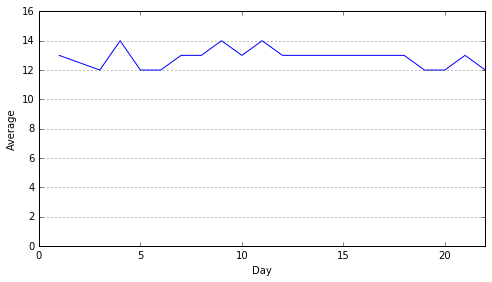

In [110]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass

### Exploring 404 Response Codes

#### Counting 404 Response Codes

Create a RDD containing only log records with a 404 response code. Make sure you `cache()` the RDD `badRecords` as we will use it in the rest of this exercise.
 
How many 404 records are in the log?

In [113]:
badRecords = (parsedLogsNewRDD
              .filter(lambda x: x[7] == 404)
              .cache())
print 'Found %d 404 URLs' % badRecords.count()

Found 6185 404 URLs


In [114]:
# TEST Counting 404
Test.assertEquals(badRecords.count(), 6185, 'incorrect badRecords.count()')
Test.assertTrue(badRecords.is_cached, 'incorrect badRecords.is_cached')

1 test passed.
1 test passed.


#### Listing 404 Response Code Records

In [117]:
badEndpoints = badRecords.map(lambda x: x[5])

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

404 URLS: [u'/imag', u'/history/apollo/a-001/images/', u'/shuttle/missions/sts-59/missions-sts-59.html', u'/shuttle/countdown/images/sfc_map.gif', u'/history/apollo/apollo-2/', u'/shuttle/missions/51-L/mission-51-l.html', u'/icons/white_ball.gif', u'/images/lf.gif', u'/shuttle/missions/sts-67/images/k95p0391.gif></a>', u'/shuttle/missions/sts-71/sts-69-info.html', u'/shuttle/mission/sts-71/images/images.html', u'/shuttle/news/sci.space.news/1295', u'/images/jpeg/', u'/technology/', u'/Shuttle/mission/mission.html', u'/shuttle/countdown/status', u'/shuttle.nasa.gov', u'/shuttle/missions/sts-83/mission-sts-83.html', u'/history/appolo/appolo-13/appolo-13.html', u'/shuttle/technology/sts-newsref/sts-toc.html', u'/shuttle/missions/sts-62/images/images.html', u'/images/rainban.gif', u'/images/crawlerway-logo.gif', u'/shutttle/missions/sts-70/images/KSC-95EC-1059.jpg', u'/stm-057.gif', u'/ksc.nasa.gov/images/ksclogo-medium.gif', u'/history/apollo/sa-1/sounds/', u'/ball3d.gif', u'/hmhome.hm.l'

In [118]:
# TEST Listing 404 records
badUniqueEndpointsSet40 = set(badUniqueEndpointsPick40)
Test.assertEquals(len(badUniqueEndpointsSet40), 40, 'badUniqueEndpointsPick40 not distinct')

1 test passed.


#### Listing the Top Twenty 404 Response Code Endpoints

In [119]:
badEndpointsCountPairTuple = badRecords.map(lambda x: (x[5],1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda v1,v2: v1+v2)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20,lambda s: -1*s[1])
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 633), (u'/pub/winvn/release.txt', 494), (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), (u'/images/nasa-logo.gif', 319), (u'/elv/DELTA/uncons.htm', 178), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), (u'/images/crawlerway-logo.gif', 120), (u'/://spacelink.msfc.nasa.gov', 117), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), (u'/history/apollo/a-001/a-001-patch-small.gif', 97), (u'/images/Nasa-logo.gif', 85), (u'/shuttle/resources/orbiters/atlantis.gif', 64), (u'/history/apollo/images/little-joe.jpg', 62), (u'/images/lf-logo.gif', 59), (u'/shuttle/resources/orbiters/discovery.gif', 56), (u'/shuttle/resources/orbiters/challenger.gif', 54), (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)]


In [120]:
Test.assertEquals(badEndpointsTop20, [(u'/pub/winvn/readme.txt', 633), 
                                      (u'/pub/winvn/release.txt', 494), 
                                      (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), 
                                      (u'/images/nasa-logo.gif', 319), 
                                      (u'/elv/DELTA/uncons.htm', 178), 
                                      (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), 
                                      (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), 
                                      (u'/images/crawlerway-logo.gif', 120), 
                                      (u'/://spacelink.msfc.nasa.gov', 117), 
                                      (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), 
                                      (u'/history/apollo/a-001/a-001-patch-small.gif', 97), 
                                      (u'/images/Nasa-logo.gif', 85), 
                                      (u'/shuttle/resources/orbiters/atlantis.gif', 64), 
                                      (u'/history/apollo/images/little-joe.jpg', 62), 
                                      (u'/images/lf-logo.gif', 59), 
                                      (u'/shuttle/resources/orbiters/discovery.gif', 56), 
                                      (u'/shuttle/resources/orbiters/challenger.gif', 54), 
                                      (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), 
                                      (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)], 
                  'incorrect badEndpointsTop20')

1 test passed.


#### Listing the Top Twenty-five 404 Response Code Hosts

In [122]:
errHostsCountPairTuple = badRecords.map(lambda x: (x[0],1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda v1,v2: v1+v2)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1*s[1])
print 'Top 25 hosts that generated errors: %s' % errHostsTop25

Top 25 hosts that generated errors: [(u'maz3.maz.net', 39), (u'piweba3y.prodigy.com', 39), (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), (u'204.62.245.32', 33), (u'163.206.104.34', 27), (u'spica.sci.isas.ac.jp', 27), (u'www-d4.proxy.aol.com', 26), (u'www-c4.proxy.aol.com', 25), (u'203.13.168.24', 25), (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), (u'scooter.pa-x.dec.com', 23), (u'crl5.crl.com', 23), (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21), (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), (u'isou24.vilspa.esa.es', 19), (u'dial055.mbnet.mb.ca', 19), (u'tigger.nashscene.com', 19)]


In [123]:
Test.assertEquals(len(errHostsTop25), 25, 'length of errHostsTop25 is not 25')
Test.assertEquals(len(set(errHostsTop25) - set([(u'maz3.maz.net', 39), (u'piweba3y.prodigy.com', 39), 
                                                (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), 
                                                (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), 
                                                (u'204.62.245.32', 33), (u'163.206.104.34', 27), 
                                                (u'spica.sci.isas.ac.jp', 27), (u'www-d4.proxy.aol.com', 26), 
                                                (u'www-c4.proxy.aol.com', 25), (u'203.13.168.24', 25), 
                                                (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), 
                                                (u'scooter.pa-x.dec.com', 23), (u'crl5.crl.com', 23), 
                                                (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), 
                                                (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21),
                                                (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), 
                                                (u'isou24.vilspa.esa.es', 19), (u'dial055.mbnet.mb.ca', 19),
                                                (u'tigger.nashscene.com', 19)])), 0, 'incorrect errHostsTop25')

1 test passed.
1 test passed.


#### Listing 404 Response Codes per Day

In [124]:
errDateCountPairTuple = badRecords.map(lambda x: (x[3].day,1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda v1,v2:v1+v2)

errDateSorted = (errDateSum
                 .sortByKey()
                 .cache())

errByDate = errDateSorted.collect()
print '404 Errors by day: %s' % errByDate

404 Errors by day: [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)]


In [125]:
# TEST 404 response codes per day
Test.assertEquals(errByDate, [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), 
                              (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), 
                              (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)], 'incorrect errByDate')
Test.assertTrue(errDateSorted.is_cached, 'incorrect errDateSorted.is_cached')

1 test passed.
1 test passed.


#### Visualizing the 404 Response Codes by Day

In [126]:
daysWithErrors404 = errDateSorted.map(lambda x: x[0]).collect()
errors404ByDay = errDateSorted.map(lambda x: x[1]).collect()

In [127]:
# TEST Visualizing the 404 Response Codes by Day
Test.assertEquals(daysWithErrors404, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect daysWithErrors404')
Test.assertEquals(errors404ByDay, [243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288], 'incorrect errors404ByDay')

1 test passed.
1 test passed.


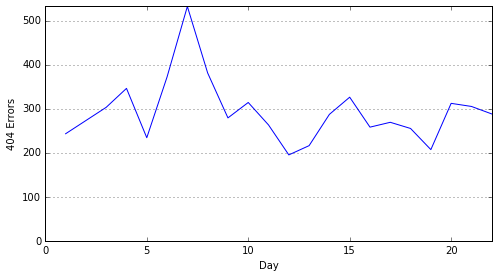

In [128]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

#### Top Five Days for 404 Response Codes 

In [129]:
topErrDate = errDateSorted.takeOrdered(5,lambda s: -1*s[1])
print 'Top Five dates for 404 requests: %s' % topErrDate

Top Five dates for 404 requests: [(7, 532), (8, 381), (6, 372), (4, 346), (15, 326)]


In [130]:
# TEST Five dates for 404 requests
Test.assertEquals(topErrDate, [(7, 532), (8, 381), (6, 372), (4, 346), (15, 326)], 'incorrect topErrDate')

1 test passed.


#### Hourly 404 Response Codes

In [131]:
hourCountPairTuple = badRecords.map(lambda x: (x[3].hour,1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda v1,v2: v1+v2)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey()
                     .cache())

errHourList = hourRecordsSorted.collect()
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)]


In [132]:
# TEST Hourly 404 response codes
Test.assertEquals(errHourList, [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)], 'incorrect errHourList')
Test.assertTrue(hourRecordsSorted.is_cached, 'incorrect hourRecordsSorted.is_cached')

1 test passed.
1 test passed.


#### Visualizing the 404 Response Codes by Hour

In [133]:
hoursWithErrors404 = hourRecordsSorted.map(lambda x: x[0]).collect()
errors404ByHours = hourRecordsSorted.map(lambda x: x[1]).collect()

In [134]:
# TEST Visualizing the 404 Response Codes by Hour
Test.assertEquals(hoursWithErrors404, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'incorrect hoursWithErrors404')
Test.assertEquals(errors404ByHours, [175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 373, 330, 268, 269, 270, 241, 234, 272], 'incorrect errors404ByHours')

1 test passed.
1 test passed.


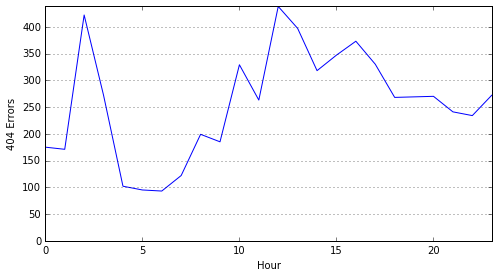

In [135]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass